### Data
Raster : Regular images
Vector : 

In [ ]:
!pip install numpy scikit-learn opencv-python-headless pillow
!pip install --upgrade earthpy
!pip install --upgrade geopandas
!pip install --upgrade rioxarray

In [1]:
import rasterio
from rasterio.windows import Window
import os

In [ ]:



def split_image_into_tiles(input_tif, output_dir, tile_size):
    """
    Splits an aerial image into non-overlapping tiles of specified size.
    
    Parameters:
    input_tif (str): Path to the input .tif file.
    output_dir (str): Directory where tiles will be saved.
    tile_size (int): Size of each tile (n x n).
    """
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Open the input GeoTIFF
    with rasterio.open(input_tif) as src:
        # Retrieve dimensions
        n_cols, n_rows = src.width, src.height
        num_tiles_x = n_cols // tile_size
        num_tiles_y = n_rows // tile_size
        
        # Iterate over each tile position
        for i in range(num_tiles_y):
            for j in range(num_tiles_x):
                # Calculate window (x, y offsets)
                x_offset = j * tile_size
                y_offset = i * tile_size
                
                # Define the window
                window = Window(x_offset, y_offset, tile_size, tile_size)
                
                # Read the windowed data
                tile_data = src.read(window=window)
                
                # Define tile filename
                tile_filename = f"tile_{i}_{j}.tif"
                tile_path = os.path.join(output_dir, tile_filename)
                
                # Define metadata for the tile
                tile_meta = src.meta.copy()
                tile_meta.update({
                    'height': tile_size,
                    'width': tile_size,
                    'transform': rasterio.windows.transform(window, src.transform)
                })
                
                # Write the tile to a new file
                with rasterio.open(tile_path, 'w', **tile_meta) as dst:
                    dst.write(tile_data)
                
                print(f"Saved {tile_path}")

# Parameters
input_tif = 'm_4209609_ne_14_060_20220809/m_4209609_ne_14_060_20220809.tif'  # Path to your input .tif file
output_dir = 'tiles'                  # Directory to save tiles
tile_size = 512                        # tile_size x tile_size

# Run the function
split_image_into_tiles(input_tif, output_dir, tile_size)

Saved tiles/tile_0_0.tif
Saved tiles/tile_0_1.tif
Saved tiles/tile_0_2.tif
Saved tiles/tile_0_3.tif
Saved tiles/tile_0_4.tif
Saved tiles/tile_0_5.tif
Saved tiles/tile_0_6.tif
Saved tiles/tile_0_7.tif
Saved tiles/tile_0_8.tif
Saved tiles/tile_0_9.tif
Saved tiles/tile_0_10.tif
Saved tiles/tile_0_11.tif
Saved tiles/tile_0_12.tif
Saved tiles/tile_0_13.tif
Saved tiles/tile_0_14.tif
Saved tiles/tile_0_15.tif
Saved tiles/tile_0_16.tif
Saved tiles/tile_0_17.tif
Saved tiles/tile_0_18.tif
Saved tiles/tile_1_0.tif
Saved tiles/tile_1_1.tif
Saved tiles/tile_1_2.tif
Saved tiles/tile_1_3.tif
Saved tiles/tile_1_4.tif
Saved tiles/tile_1_5.tif
Saved tiles/tile_1_6.tif
Saved tiles/tile_1_7.tif
Saved tiles/tile_1_8.tif
Saved tiles/tile_1_9.tif
Saved tiles/tile_1_10.tif
Saved tiles/tile_1_11.tif
Saved tiles/tile_1_12.tif
Saved tiles/tile_1_13.tif
Saved tiles/tile_1_14.tif
Saved tiles/tile_1_15.tif
Saved tiles/tile_1_16.tif
Saved tiles/tile_1_17.tif
Saved tiles/tile_1_18.tif
Saved tiles/tile_2_0.tif
Saved t

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
from sklearn.preprocessing import StandardScaler
from shutil import copyfile

In [135]:
# def extract_edge_features(image_path):
#     image = Image.open(image_path).convert("L")  # Convert to grayscale
#     image_np = np.array(image)
    
#     # Apply Canny Edge Detection
#     edges = cv2.Canny(image_np, threshold1=100, threshold2=200)
    
#     # Count edge pixels as feature
#     edge_count = np.sum(edges > 0)
#     total_pixels = edges.size
#     edge_density = edge_count / total_pixels  # Ratio of edge pixels to total pixels
    
#     return np.array([edge_density])


In [11]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog

from skimage.feature import hog
from scipy import stats

In [133]:
def lbp_and_hog(image_gray):

    features = []
    radius = 3
    n_points = 10 * radius
    lbp = local_binary_pattern(image_gray, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=n_points + 2, density=True)
    features.extend(lbp_hist)

    # HOG
    hog_features = hog(image_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    features.extend(hog_features[:10])  # Taking first 10 HOG features

    return features


In [134]:
# GLCM features
def glcm_features(img_gray):
    features = []
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(img_gray, distances, angles, 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')

    features.extend(contrast.tolist()[0])
    features.extend(dissimilarity.tolist()[0])
    features.extend(homogeneity.tolist()[0])
    return features

## Test

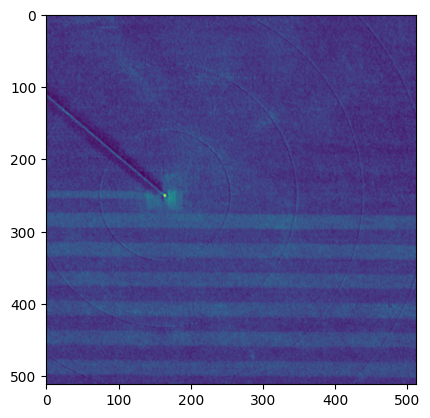

In [136]:
img_path = "/Users/robinakan/Documents/USD/CV/naip_image_processing/tiles/tile_0_0.tif"
image = Image.open(img_path).convert("RGB")
image_np = np.array(image)

image_gr = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
plt.imshow(image_gr)

In [138]:
import os
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
from sklearn.preprocessing import StandardScaler
from shutil import copyfile

def extract_features(image_path):
    """
    Extract color histogram features from the image.
    
    Parameters:
    image_path (str): Path to the image file.
    
    Returns:
    np.array: Flattened histogram features.
    """

    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    image_gr = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

    image_feature =  np.array( glcm_features(image_gr) + lbp_and_hog(image_gr) )
    
    return image_feature

In [142]:
tile_dir = "./tiles"
# Collect all tile paths
tile_paths = [os.path.join(tile_dir, fname) for fname in os.listdir(tile_dir) if fname.endswith('.tif')]

# Extract features for each tile
features = np.array([extract_features(path) for path in tile_paths])

# Normalization 
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [143]:
# Apply KMeans clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
labels = kmeans.fit_predict(features_scaled)

In [150]:
cluster_root_dir = './clusters'


In [151]:
# for i in np.unique(labels):
#     os.makedirs(f"{cluster_dir}/{i}")

In [152]:
# Save images in separate folders based on clusters
for idx, tile_path in enumerate(tile_paths):
    cluster_label = labels[idx]
    cluster_dir = os.path.join(cluster_root_dir, f"cluster_{cluster_label}")
    os.makedirs(cluster_dir, exist_ok=True)
    copyfile(tile_path, os.path.join(cluster_dir, os.path.basename(tile_path)))
    print(f"Saved {tile_path} to {cluster_dir}")

Saved ./tiles/tile_21_16.tif to ./clusters/cluster_0
Saved ./tiles/tile_6_2.tif to ./clusters/cluster_1
Saved ./tiles/tile_2_16.tif to ./clusters/cluster_0
Saved ./tiles/tile_4_0.tif to ./clusters/cluster_1
Saved ./tiles/tile_17_17.tif to ./clusters/cluster_2
Saved ./tiles/tile_19_12.tif to ./clusters/cluster_2
Saved ./tiles/tile_2_6.tif to ./clusters/cluster_1
Saved ./tiles/tile_15_12.tif to ./clusters/cluster_0
Saved ./tiles/tile_14_9.tif to ./clusters/cluster_2
Saved ./tiles/tile_21_0.tif to ./clusters/cluster_1
Saved ./tiles/tile_23_13.tif to ./clusters/cluster_1
Saved ./tiles/tile_18_4.tif to ./clusters/cluster_1
Saved ./tiles/tile_0_4.tif to ./clusters/cluster_1
Saved ./tiles/tile_23_2.tif to ./clusters/cluster_2
Saved ./tiles/tile_0_13.tif to ./clusters/cluster_0
Saved ./tiles/tile_0_12.tif to ./clusters/cluster_0
Saved ./tiles/tile_23_3.tif to ./clusters/cluster_1
Saved ./tiles/tile_0_5.tif to ./clusters/cluster_1
Saved ./tiles/tile_23_12.tif to ./clusters/cluster_1
Saved ./til

## Plot Sentinel Image

In [1]:
import rasterio
from rasterio.windows import Window
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# RGB Normalization bands
def preprocess(band):
    # Step 1: Divide by 10,000
    band = band / 10000.0
    
    # Step 2: Clip to the range [0, 0.3]
    band = np.clip(band, 0, 0.3)
    
    return band

# Generic Normalization
def normalize_band(band, clip=False):
    if clip:
        band = preprocess(band)
    return (band - band.min()) / (band.max() - band.min())

def load_data(image_arr):
    # Assuming `data` is your numpy array of shape (27, 600, 1000)
    # Extract the Blue, Green, and Red bands
    blue = image_arr[2]
    green = image_arr[3]
    red = image_arr[4]
    ndvi = image_arr[-1]  # Last band for NDVI

    red_normalized = normalize_band(red, 0) # .astype(np.uint8)
    green_normalized = normalize_band(green, 0) # .astype(np.uint8)
    blue_normalized = normalize_band(blue, 0) # .astype(np.uint8)
    ndvi_normalized = normalize_band(ndvi)

    # Stack the normalized bands to create an RGB image
    rgb_image = np.stack([red_normalized, green_normalized, blue_normalized], axis=-1)

    return rgb_image, ndvi_normalized

In [ ]:
# before_tif = 'sentinel/NDVI_Before_Tillage.tif'
# after_tif = 'sentinel/NDVI_After_Tillage.tif'

before_tif = 'sentinel/NDVI_Before_Tillage.tif'
after_tif = 'sentinel/NDVI_After_Tillage.tif'



## Take a snippet for image
ROW_START = 200
ROW_END = 800
COL_START = 200
COL_END = 1200

with rasterio.open(before_tif) as src:
    before_desc = src.descriptions
    before = src.read()

with rasterio.open(after_tif) as src:
    after_desc = src.descriptions
    after = src.read()


before = before[:, ROW_START:ROW_END, COL_START:COL_END ]
after = after[:, ROW_START:ROW_END, COL_START:COL_END ]

before_rgb, before_ndvi = load_data(before)
after_rgb, after_ndvi = load_data(after)

In [4]:
before_ndvi.shape

(600, 1000)

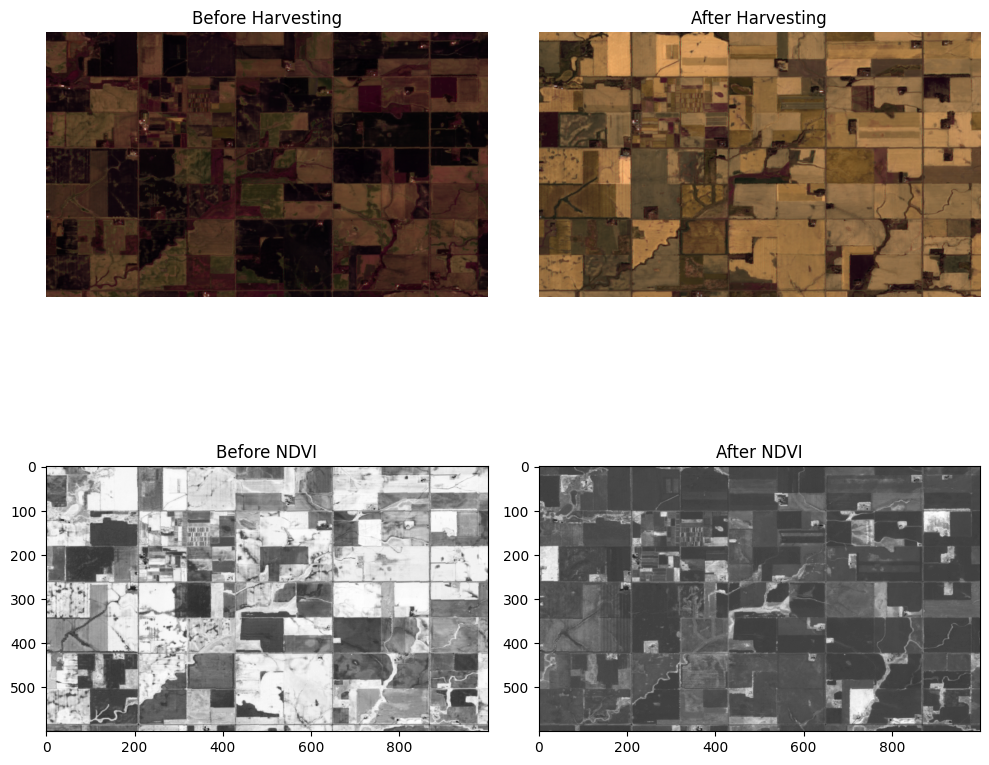

In [52]:
# plt.figure(figsize=(12, 6))  # Create a figure with a width and height
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot the "before" image
axes[0,0].imshow(before_rgb)
axes[0,0].set_title("Before Harvesting")
axes[0,0].axis('off')  # Turn off the axis

# Save just the portion _inside_ the second axis's boundaries
extent = axes[0,0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig('ax2_figure.png', bbox_inches=extent)
# Pad the saved area by 10% in the x-direction and 20% in the y-direction
fig.savefig('ax2_figure_expanded.png', dpi=300, bbox_inches=extent.expanded(1.1, 1.2), pad_inches=0 )

# axes[0,0].savefig("high_quality_image1.png", dpi=300, bbox_inches='tight', pad_inches=0)

# Plot the "after" image
axes[0,1].imshow(after_rgb)
axes[0,1].set_title("After Harvesting")
axes[0,1].axis('off')  # Turn off the axis

# Plot the "before" ndvi image
axes[1, 0].imshow(before_ndvi, cmap='gray')
axes[1, 0].set_title("Before NDVI")

# Plot the "after" ndvi image
axes[1, 1].imshow(after_ndvi, cmap='gray')
axes[1, 1].set_title("After NDVI")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

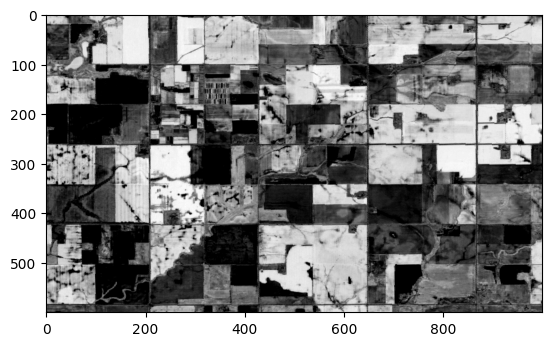

In [13]:
## Prepare Label. This shows cropland. 
# See how much change happened before and after ... 
change = before_ndvi - after_ndvi
# Only use change from before to After.
change[change<=0] = 0
change = ( change - change.min() ) / (change.max() - change.min())

plt.imshow(change, cmap='gray')
plt.savefig("high_quality_image1.png", dpi=300, bbox_inches='tight', pad_inches=0)

In [14]:
before.shape, after.shape, change.shape

((27, 600, 1000), (27, 600, 1000), (600, 1000))

In [114]:
# Define the tile size
TILE_SIZE = 256

In [17]:
# Assuming your original array is named `array` with shape (N, 1443, 1499)
_, H, W = before.shape

# Calculate the number of tiles that fit in each dimension
num_tiles_y = H // TILE_SIZE  # Number of tiles along the height
num_tiles_x = W // TILE_SIZE  # Number of tiles along the width

print(num_tiles_x, num_tiles_y)

# Initialize a list to store the tiles
tiles_before = []
tiles_after = []
tiles_changes = []

# Loop through the height and width to extract each tile
for i in range(num_tiles_y):
    for j in range(num_tiles_x):
        row_start, row_end = i*TILE_SIZE, (i+1)*TILE_SIZE
        col_start, col_end = j*TILE_SIZE, (j+1)*TILE_SIZE
 
        # Extract the tile
        tile_before = before[:, row_start:row_end, col_start:col_end ]
        tile_after = after[ :, row_start:row_end, col_start:col_end ]
        tile_change = change[ row_start:row_end, col_start:col_end ]
        tiles_before.append(tile_before)
        tiles_after.append(tile_after)
        tiles_changes.append(tile_change)

# Convert list of tiles to numpy array
tiles_before = np.array(tiles_before)
tiles_after = np.array(tiles_after)
tiles_changes = np.array(tiles_changes)

# print(tiles_before.shape)  # Expected shape: (num_tiles_y * num_tiles_x, N, 256, 256)

3 2


In [20]:
def per_channel_normalize(x):
    '''
    x : numpy array of shape (channel, height, width)
    '''
    out = (x.T - x.min((1,2))) / (x.max((1,2)) - x.min((1,2)))
    return out.transpose(2,1,0)

/var/folders/5q/d5sngbr11bj5s27jzhrdww2r0000gn/T/ipykernel_24665/3939977211.py:5: RuntimeWarning: invalid value encountered in divide
  out = (x.T - x.min((1,2))) / (x.max((1,2)) - x.min((1,2)))


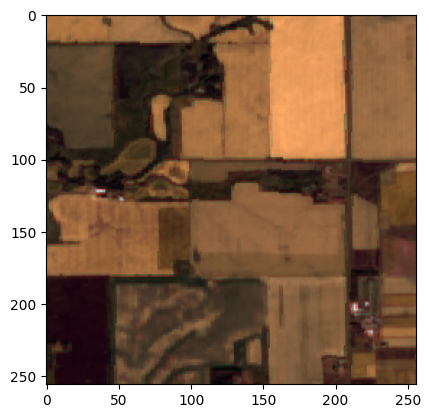

In [28]:
plt.imshow(
    per_channel_normalize( tiles_after[0] ) # shape is : c,h,w
    .transpose(1,2,0) # change to : h,w,c
    [ :, : , [4,3,2] ] ) # select specific channels

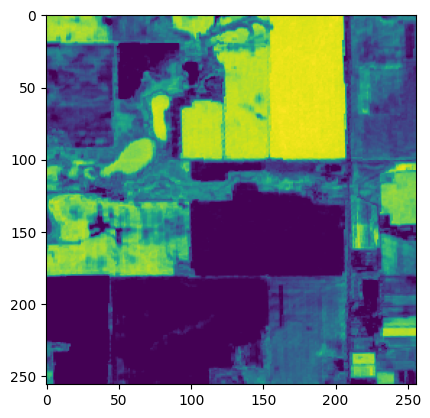

In [25]:
plt.imshow(tiles_changes[0] )

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

In [115]:
CHANNELS_INDEXES = [4,3,2] ## channels to use in modeling
BATCH_SIZE = 6

NUM_CHANNELS = len(CHANNELS_INDEXES)

In [116]:
class CropLandDataset(Dataset):
    def __init__(self, X_images_before, X_images_after, Y_masks, channels_idx=[], transform=None):
        self.X_images_before = X_images_before
        self.X_images_after = X_images_after
        self.Y_masks = Y_masks
        self.transform = transform

        self.X_combined = np.concatenate( (self.X_images_before, self.X_images_after) , axis=0)
        self.Y_combined = np.concatenate( (self.Y_masks, self.Y_masks) , axis=0)
        if not channels_idx:
            self.channels_idx = CHANNELS_INDEXES # Use RGB Bands by default
        else:
            self.channels_idx = channels_idx # Use supplied band otherwise

    def __len__(self):
        return len(self.X_combined)

    def __getitem__(self, idx):
        # print('index is :', idx)
        # print("Len X : ", len(self.X_combined))
        # print("Len Y : ", len(self.Y_combined))
        X = self.X_combined[idx]
        # X = X.transpose( (1,2,0) )
        X = X[ self.channels_idx, : , :  ]
        X = per_channel_normalize(X)
        
        Y = self.Y_combined[idx]

        # print(X.shape, Y.shape)
        if self.transform:
            print("Applying Transformation ... ")
            X = self.transform(X)
        return X, Y


# Define any transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales pixel values between 0 and 1
])

# Create dataset and dataloader
dataset = CropLandDataset(
    X_images_before=tiles_before,
    X_images_after=tiles_after,
    Y_masks=tiles_changes,
    transform=None
    )

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [118]:
for test in dataloader:
    break

In [119]:
test[0][0].shape, test[1][0].shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

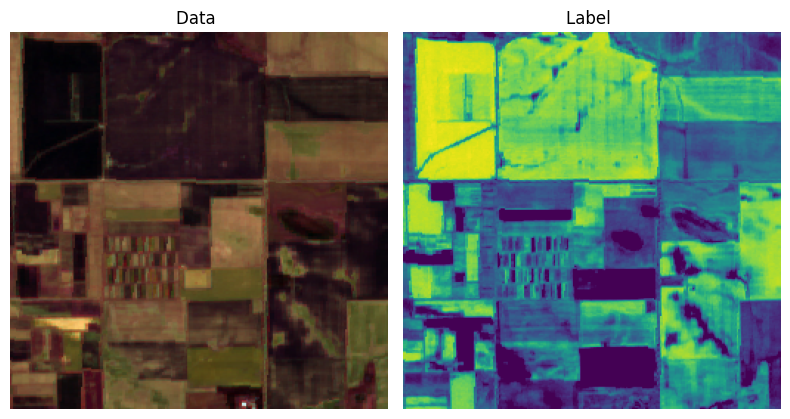

In [120]:
## Plot second item of batch
fig, axes = plt.subplots(1, 2, figsize=(8, 8))

# Plot the "input" 
axes[0].imshow(  test[0][1].permute((1,2,0) )  )
axes[0].set_title("Data ")
axes[0].axis('off')  # Turn off the axis

# Plot the "label" 
axes[1].imshow(test[1][1])
axes[1].set_title("Label ")
axes[1].axis('off')  # Turn off the axis

plt.tight_layout()
plt.show()

In [121]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x1 = self.encoder(x)
        # print(x1.shape)
        x2 = self.middle(x1)
        # print(x2.shape)
        x3 = self.up(x2)
        # print(x3.shape)
        x4 = self.decoder(x3)
        # print(x4.shape)
        return x4

# Create an instance of the U-Net
in_channels = NUM_CHANNELS  # Number of channels in X
out_channels = 1  # Single-channel output for probability map
model = UNet(in_channels, out_channels)

In [122]:
# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # This combines sigmoid and binary cross-entropy in one step
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [123]:
## Run a test output of Model .. 
test_output = model(test[0].float()) # Input be B, C , H, W , Output of shape : B, 1, H , W

In [124]:
test_output.squeeze().shape, test[1].shape

(torch.Size([6, 256, 256]), torch.Size([6, 256, 256]))

In [127]:
for X_batch, Y_batch in dataloader:
    print(len(X_batch))

6
6


In [130]:
num_epochs = 50  # Adjust based on your needs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, Y_batch in dataloader:
        X_batch, Y_batch = X_batch.float(), Y_batch.float()  # Ensure data types
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), Y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Todo : Add a validation dataloader like above ..

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

Epoch [1/50], Loss: 0.6346
Epoch [2/50], Loss: 0.6338
Epoch [3/50], Loss: 0.6330
Epoch [4/50], Loss: 0.6322
Epoch [5/50], Loss: 0.6313
Epoch [6/50], Loss: 0.6303
Epoch [7/50], Loss: 0.6295
Epoch [8/50], Loss: 0.6285
Epoch [9/50], Loss: 0.6275
Epoch [10/50], Loss: 0.6264
Epoch [11/50], Loss: 0.6252
Epoch [12/50], Loss: 0.6240
Epoch [13/50], Loss: 0.6227
Epoch [14/50], Loss: 0.6213
Epoch [15/50], Loss: 0.6199
Epoch [16/50], Loss: 0.6185
Epoch [17/50], Loss: 0.6170
Epoch [18/50], Loss: 0.6154
Epoch [19/50], Loss: 0.6140
Epoch [20/50], Loss: 0.6125
Epoch [21/50], Loss: 0.6111
Epoch [22/50], Loss: 0.6097
Epoch [23/50], Loss: 0.6084
Epoch [24/50], Loss: 0.6072
Epoch [25/50], Loss: 0.6060
Epoch [26/50], Loss: 0.6049
Epoch [27/50], Loss: 0.6039
Epoch [28/50], Loss: 0.6027
Epoch [29/50], Loss: 0.6016
Epoch [30/50], Loss: 0.6006
Epoch [31/50], Loss: 0.5999
Epoch [32/50], Loss: 0.5987
Epoch [33/50], Loss: 0.5981
Epoch [34/50], Loss: 0.5967
Epoch [35/50], Loss: 0.5962
Epoch [36/50], Loss: 0.5953
E

In [141]:
len(test[1]), test[1][0]

(6,
 tensor([[0.8331, 0.8514, 0.8298,  ..., 0.3364, 0.3160, 0.2564],
         [0.8469, 0.8263, 0.8025,  ..., 0.4096, 0.3625, 0.2876],
         [0.8402, 0.8022, 0.8050,  ..., 0.4716, 0.4547, 0.3928],
         ...,
         [0.3780, 0.4621, 0.4951,  ..., 0.0000, 0.0000, 0.1176],
         [0.3944, 0.4343, 0.5096,  ..., 0.0000, 0.0000, 0.1034],
         [0.5015, 0.5313, 0.5528,  ..., 0.0000, 0.0000, 0.0402]],
        dtype=torch.float64))

In [134]:
## Now look at how model is performing
with torch.no_grad():  
    ## Run a test output of Model .. 
    test_output = model(test[0].float())

In [147]:
actual_image = test[0][0].permute((1,2,0) ) # First example of test-batch
actual_croparea = test[1][0] # First example of test-batch
pred_croparea = test_output.squeeze()[0]

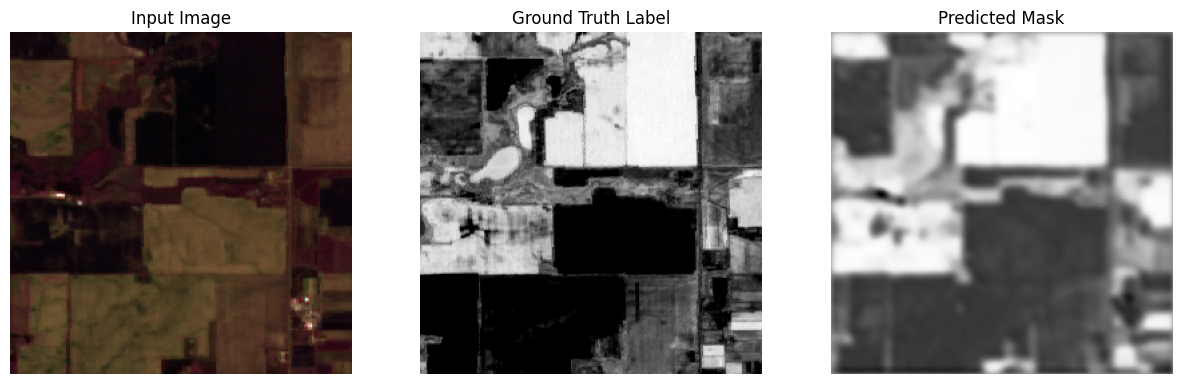

In [ ]:
# Function to plot input image and prediction side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the input image
ax[0].imshow( actual_image )  
ax[0].set_title("Input Image")
ax[0].axis('off')

# Plot the ground truth label
ax[1].imshow(actual_croparea, cmap='gray')
ax[1].set_title("Ground Truth Label")
ax[1].axis('off')

# Plot the prediction
ax[2].imshow(pred_croparea, cmap='gray')
ax[2].set_title("Predicted Mask")
ax[2].axis('off')

plt.show()